### Implementing Convolutional Neural Networks on OCTMNIST

Imports & Reproducibility

In [1]:
#imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import count

import medmnist
from medmnist import INFO, Evaluator

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

#Setting Random Seed
np.random.seed(12345) 
torch.manual_seed(12345)

### Convolutional Neural Networks on OCTMNIST

#### Data loading and inspection
- Follow instructions at https://github.com/MedMNIST/MedMNIST to download and load the data.
Display at least ten images for each class for each train test and validation set.

In [2]:
#Function to print images
def print_image(dataset,label):
    i=0
    for img,lbl in dataset:
        if lbl == label:
            display(img)
            i = i+1
        if i == 10:
            break
            
#load the data
DataClass = getattr(medmnist, 'OCTMNIST')

oct_train_dataset = DataClass(split='train', download=True)
oct_validation_dataset = DataClass(split='val', download=True)
oct_test_dataset = DataClass(split='test', download=True)

# getting and printing images from Training Set
print("Images classified as choroidal neovascularization from Training set")
print_image(oct_train_dataset,0)
print("Images classified as diabetic macular edema from Training set")
print_image(oct_train_dataset,1)
print("Images classified as drusen from Training set")
print_image(oct_train_dataset,2)
print("Images classified as normal from Training set")
print_image(oct_train_dataset,3)

# getting and printing images from Valdiation Set
print("Images classified as choroidal neovascularization from Validation set")
print_image(oct_validation_dataset,0)
print("Images classified as diabetic macular edema from Validation set")
print_image(oct_validation_dataset,1)
print("Images classified as drusen from Validation set")
print_image(oct_validation_dataset,2)
print("Images classified as normal from Validation set")
print_image(oct_validation_dataset,3)

# getting and printing images from Test Set
print("Images classified as choroidal neovascularization from Test set")
print_image(oct_test_dataset,0)
print("Images classified as diabetic macular edema from Test set")
print_image(oct_test_dataset,1)
print("Images classified as drusen from Test set")
print_image(oct_test_dataset,2)
print("Images classified as normal from Test set")
print_image(oct_test_dataset,3)



Using downloaded and verified file: C:\Users\svpol\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\svpol\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\svpol\.medmnist\octmnist.npz
Images classified as choroidal neovascularization from Training set


Images classified as diabetic macular edema from Training set


Images classified as drusen from Training set


Images classified as normal from Training set


Images classified as choroidal neovascularization from Validation set


Images classified as diabetic macular edema from Validation set


Images classified as drusen from Validation set


Images classified as normal from Validation set


Images classified as choroidal neovascularization from Test set


Images classified as diabetic macular edema from Test set


Images classified as drusen from Test set


Images classified as normal from Test set


#### Designing a 2Conv 2FC  Convolutional Neural Network
 - Design a CNN with two Conv layers and two FC layers. Train the model on the training set,use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics Training Accuracy, Validation Accuracy, Test Accuracy and Training Time.

In [3]:
#Defining parameters
NUM_EPOCHS = 5
BATCH_SIZE = 128
lr = 0.1
DataClass = getattr(medmnist,'OCTMNIST')

#Valriable for holding metrics
M1_NN = {}
M2_NN = {}
M3_NN = {}
M4_NN = {}

#### Data Preprocessing

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\svpol\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\svpol\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\svpol\.medmnist\octmnist.npz


#### Create CNN models

In [5]:
#Create three seperate CNN models with 2 Convolution and 2 Fully connected Layers
class CNN1(torch.nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 12, 3) #1 input channel, 12 outpur channels and kernel size 3
        self.conv2 = torch.nn.Conv2d(12, 16, 3)
        
        self.pool = torch.nn.MaxPool2d(2, 2)
    
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5) #1 input channel, 6 outpur channels and kernel size 5
        self.conv2 = torch.nn.Conv2d(6, 12, 5)
        
        self.pool = torch.nn.MaxPool2d(2, 2)
    
        self.fc1 = torch.nn.Linear(12*4*4,90)
        self.fc2 = torch.nn.Linear(90, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 12*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
class CNN3(torch.nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5) #1 input channel, 6 outpur channels and kernel size 5
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        #No pooling layer used
        self.fc1 = torch.nn.Linear(16*20*20,90)
        self.fc2 = torch.nn.Linear(90, 4)

    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = (F.relu(self.conv2(x)))
        x = x.view(-1, 16*20*20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Train and Evaluate the models

In [6]:
#function to train the model and record time
def train_cnn(CNN,NUM_EPOCHS,train_loader):
    optimizer = optim.SGD(CNN.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    start = time.perf_counter()

    for epoch in range(NUM_EPOCHS):
        CNN.train()
        for inputs, targets in (train_loader):
            optimizer.zero_grad()
            outputs = CNN(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    elapsed_time = time.perf_counter() - start
    return CNN,elapsed_time

#Function to calculate accuracy
def get_accu(split,CNN):
    CNN.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    if split == 'train':
        data_loader = train_loader_at_eval
    elif split == 'val':
        data_loader = val_loader 
    else:
        data_loader = test_loader

    with torch.no_grad():
        
        for inputs, targets in data_loader:
            outputs = CNN(inputs)
            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)
            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        evaluator = Evaluator('octmnist', split)
        metrics = evaluator.evaluate(y_score)
        return metrics

#initialize models
myCNN1 = CNN1()
myCNN2 = CNN2()
myCNN3 = CNN3()

#train models and compute elapsed time
myCNN1, elapsed_time1 = train_cnn(myCNN1,NUM_EPOCHS,train_loader)
myCNN2, elapsed_time2 = train_cnn(myCNN2,NUM_EPOCHS,train_loader)
myCNN3, elapsed_time3 = train_cnn(myCNN3,NUM_EPOCHS,train_loader)

#get validation accuracy
val_acc1 = get_accu('val',myCNN1)[1]
val_acc2 = get_accu('val',myCNN2)[1]
val_acc3 = get_accu('val',myCNN3)[1]

#pick the highest validation accuracy and the use corresponding model to get the required metrics
if val_acc1 > val_acc2 and val_acc1 > val_acc3:
    M1_NN['2N'] = get_accu('train',myCNN1)[1]
    M2_NN['2N'] = val_acc1
    M3_NN['2N'] = get_accu('test',myCNN1)[1]
    M4_NN['2N'] = elapsed_time1
elif val_acc2 > val_acc1 and val_acc2 > val_acc3:
    M1_NN['2N'] = get_accu('train',myCNN2)[1]
    M2_NN['2N'] = val_acc2
    M3_NN['2N'] = get_accu('test',myCNN2)[1]
    M4_NN['2N'] = elapsed_time2
elif val_acc3 > val_acc1 and val_acc3 > val_acc2:
    M1_NN['2N'] = get_accu('train',myCNN3)[1]
    M2_NN['2N'] = val_acc3
    M3_NN['2N'] = get_accu('test',myCNN3)[1]
    M4_NN['2N'] = elapsed_time3
    
print(f"Training Accuracy : {M1_NN['2N']}\nValidation Accuracy : {M2_NN['2N']}\nTest Accuracy : {M3_NN['2N']}\nTraining Time : {M4_NN['2N']}")

Training Accuracy : 0.8277337218010402
Validation Accuracy : 0.8252400295420975
Test Accuracy : 0.621
Training Time : 135.71879280000002


#### Designing a 3Conv 3FC  Convolutional Neural Network
 - Design a CNN with three Conv layers and three FC layers. Train the model on the training set,use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics Training Accuracy, Validation Accuracy, Test Accuracy and Training Time.

In [7]:
#Create three seperate CNN models with 3 Convolution and 3 Fully connected Layers
class CNN31(nn.Module):
    def __init__(self):
        super(CNN31, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, padding=2)#1 input channel, 10 outpur channels, kernel size 5 and padding 2
        self.conv2 = nn.Conv2d(10, 16, 5,padding=2)
        self.conv3 = nn.Conv2d(16, 24, 5,padding=2)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(24 * 3 * 3, 90)
        self.fc2 = nn.Linear(90, 60)
        self.fc3 = nn.Linear(60, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 24 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class CNN32(nn.Module):
    def __init__(self):
        super(CNN32, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) #1 input channel, 6 outpur channels and kernel size 3
        self.conv2 = nn.Conv2d(6, 12, 3)
        self.conv3 = nn.Conv2d(12, 24, 3)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(24 * 1 * 1, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 24 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class CNN33(nn.Module):
    def __init__(self):
        super(CNN33, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2) #1 input channel, 6 outpur channels, kernel size 5 and padding 2
        self.conv2 = nn.Conv2d(6, 12, 5,padding=2)
        self.conv3 = nn.Conv2d(12, 24, 5,padding=2)
        #No pooling layer used
        
        self.fc1 = nn.Linear(24 * 28 * 28, 30)
        self.fc2 = nn.Linear(30, 15)
        self.fc3 = nn.Linear(15, 4)

    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = (F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = x.view(-1, 24 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Train and Evaluate the models

In [8]:
#initialize models
myCNN31 = CNN31()
myCNN32 = CNN32()
myCNN33 = CNN33()

#train models and compute elapsed time
myCNN31, elapsed_time31 = train_cnn(myCNN31,NUM_EPOCHS,train_loader)
myCNN32, elapsed_time32 = train_cnn(myCNN32,NUM_EPOCHS,train_loader)
myCNN33, elapsed_time33 = train_cnn(myCNN33,NUM_EPOCHS,train_loader)

#get validation accuracy
val_acc31 = get_accu('val',myCNN31)[1]
val_acc32 = get_accu('val',myCNN32)[1]
val_acc33 = get_accu('val',myCNN33)[1]

#pick the highest validation accuracy and the use corresponding model to get the required metrics
if val_acc31 > val_acc32 and val_acc31 > val_acc33:
    M1_NN['3N'] = get_accu('train',myCNN31)[1]
    M2_NN['3N'] = val_acc31
    M3_NN['3N'] = get_accu('test',myCNN31)[1]
    M4_NN['3N'] = elapsed_time31
elif val_acc32 > val_acc31 and val_acc32 > val_acc33:
    M1_NN['3N'] = get_accu('train',myCNN32)[1]
    M2_NN['3N'] = val_acc32
    M3_NN['3N'] = get_accu('test',myCNN32)[1]
    M4_NN['3N'] = elapsed_time32
elif val_acc33 > val_acc31 and val_acc33 > val_acc32:
    M1_NN['3N'] = get_accu('train',myCNN33)[1]
    M2_NN['3N'] = val_acc33
    M3_NN['3N'] = get_accu('test',myCNN33)[1]
    M4_NN['3N'] = elapsed_time33
    
print(f"Training Accuracy : {M1_NN['3N']}\nValidation Accuracy : {M2_NN['3N']}\nTest Accuracy : {M3_NN['3N']}\nTraining Time : {M4_NN['3N']}")

Training Accuracy : 0.8249125434717933
Validation Accuracy : 0.8262555391432792
Test Accuracy : 0.642
Training Time : 113.29039820000003


### Performance comparison

Summarise each of the four metrics from the two models using one or more bar graphs.


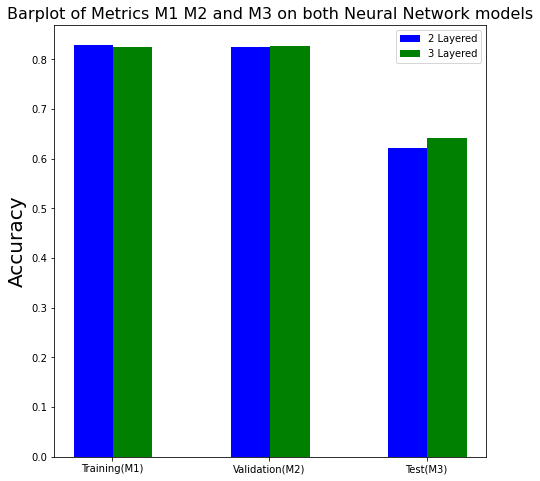

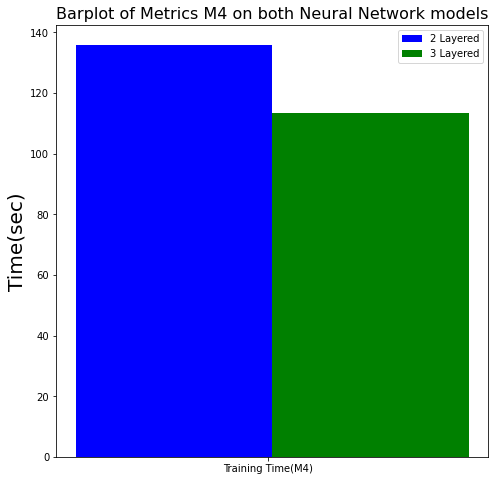

In [9]:
#Create a compatible dataset to plot the graph

X_points = np.arange(3)
a_data = [M1_NN['2N'],M2_NN['2N'],M3_NN['2N']]
b_data = [M1_NN['3N'],M2_NN['3N'],M3_NN['3N']]
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(X_points, a_data, color = 'b', width = 0.25)
ax.bar(X_points+0.25, b_data, color = 'g', width = 0.25)
ax.set_ylabel('Accuracy',fontsize=20)
ax.set_title("Barplot of Metrics M1 M2 and M3 on both Neural Network models",fontsize=16)
ax.set_xticks(X_points+0.12)
ax.set_xticklabels(labels=['Training(M1)','Validation(M2)','Test(M3)'])
ax.legend(['2 Layered','3 Layered'],prop={'size': 10})

X_points = np.arange(1)
fig2 = plt.figure(figsize=(6,6))                           
ax2 = fig2.add_axes([0,0,1,1])
ax2.bar(X_points, M4_NN['2N'], color = 'b', width = 0.25)
ax2.bar(X_points+0.25, M4_NN['3N'], color = 'g', width = 0.25)
ax2.set_ylabel('Time(sec)',fontsize=20)
ax2.set_title("Barplot of Metrics M4 on both Neural Network models",fontsize=16)
ax2.set_xticks(X_points+0.12)
ax2.set_xticklabels(labels=['Training Time(M4)'])
ax2.legend(['2 Layered','3 Layered'],prop={'size': 10})

1. Experimenting with different CNN models, noticed that increasing the convolution layers results in increased accuracy and while removing pooling layers results in much lower accuray along with much higher training times
2. Also Noticed that between the two neural networks the models with 2Convolution Layers and 2 Fully connected layers have a higher accuracy score and lower training time compared to the 3 Convultion Layer and 3 Fully connected layer Neural Neteworks